### Notebook to start exploring sequentialness of representation using ANOVA encoding instead of contribution to decoding


In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

### What does fraction of variance explained look like for certain single units?

In [12]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500
args.subject = "SA"
args.trial_event = "StimOnset"
res = io_utils.read_anova_good_units(args, "all", "")

In [13]:
res.sort_values(by="x_BeliefPref_comb_time_fracvar", ascending=False)[["x_BeliefPref_comb_time_fracvar", "PseudoUnitID", "feat", "WindowEndMilli", "BeliefPref_99th"]]
res["sig_ratio"] = res.x_BeliefPref_comb_time_fracvar / res.BeliefPref_99th

In [14]:
max_sig = res.groupby(["PseudoUnitID", "feat"]).sig_ratio.max().reset_index(name="max_sig_ratio")
max_sig = max_sig.sort_values(by="max_sig_ratio", ascending=False)

In [15]:
max_sig

PseudoUnitID      feat  max_sig_ratio
4586    2018091923      STAR       4.957150
4504    2018091907     GREEN       3.170190
1559    2018080317   MAGENTA       3.120736
3650    2018090618    SQUARE       3.048846
2730    2018082105    RIPPLE       3.033479
...            ...       ...            ...
5218    2018092601  TRIANGLE            NaN
5479    2018100106     GREEN            NaN
5480    2018100106   MAGENTA            NaN
5481    2018100106  POLKADOT            NaN
5728    2018100412   MAGENTA            NaN

[6149 rows x 3 columns]

### Plot some examples with high significance ratios

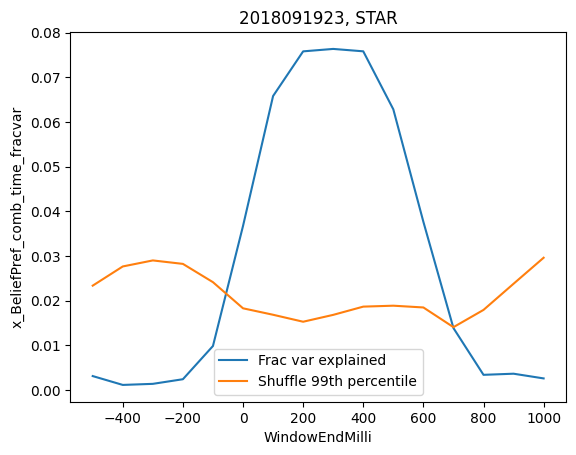

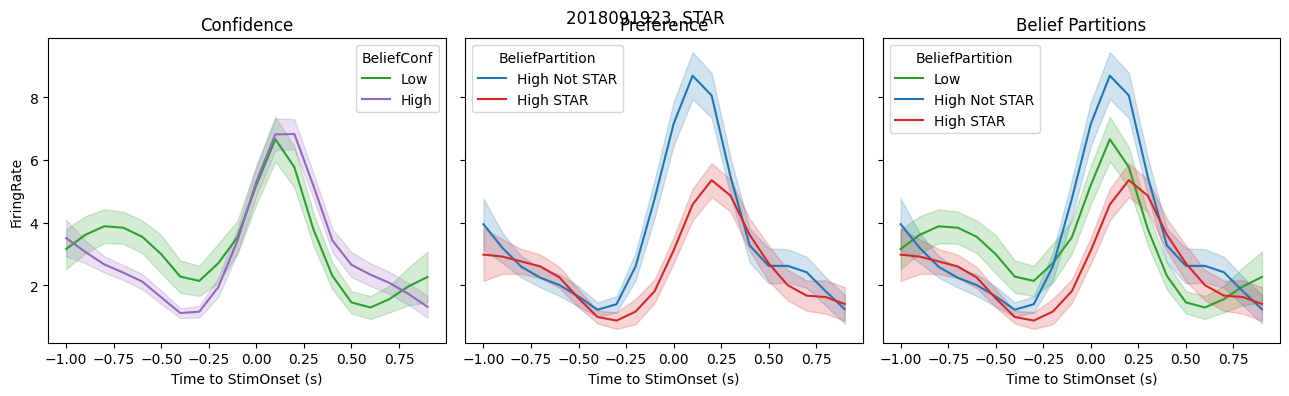

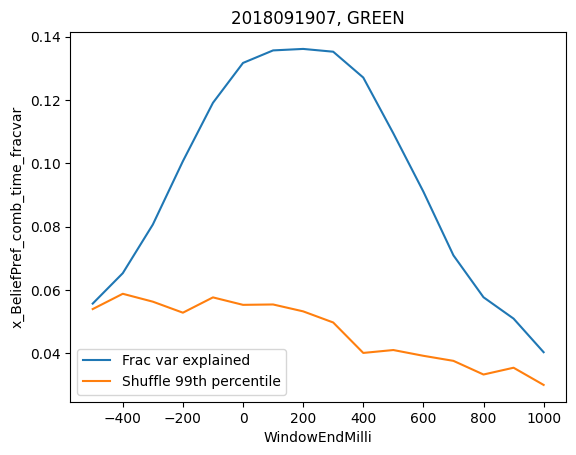

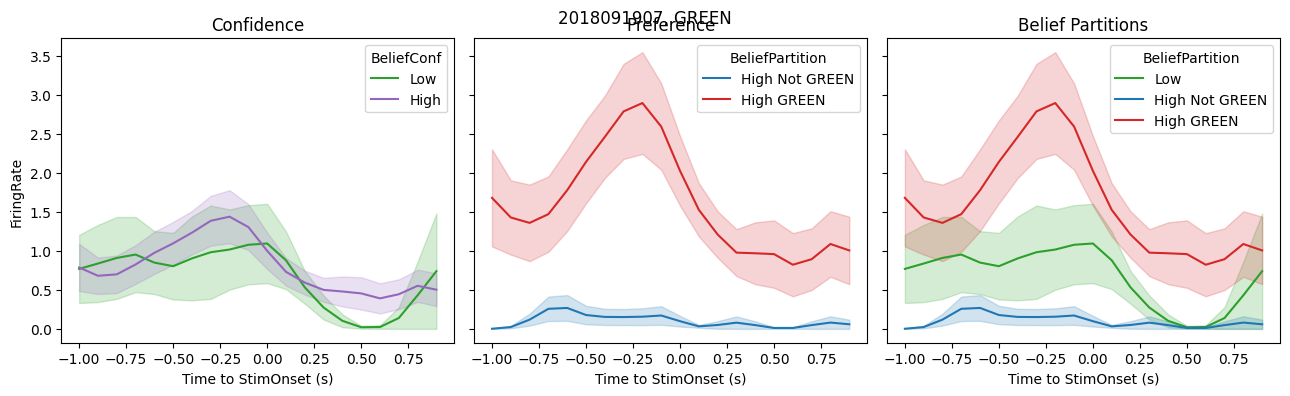

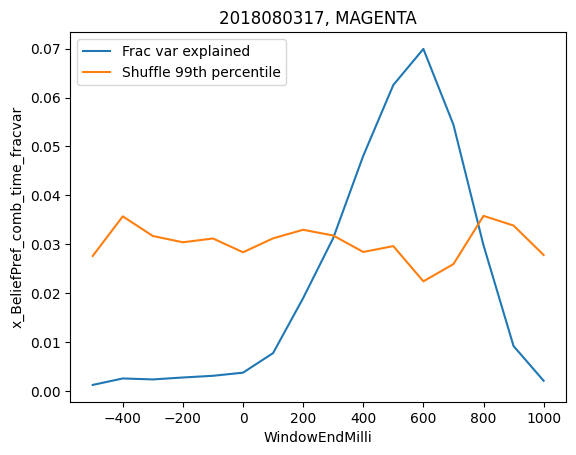

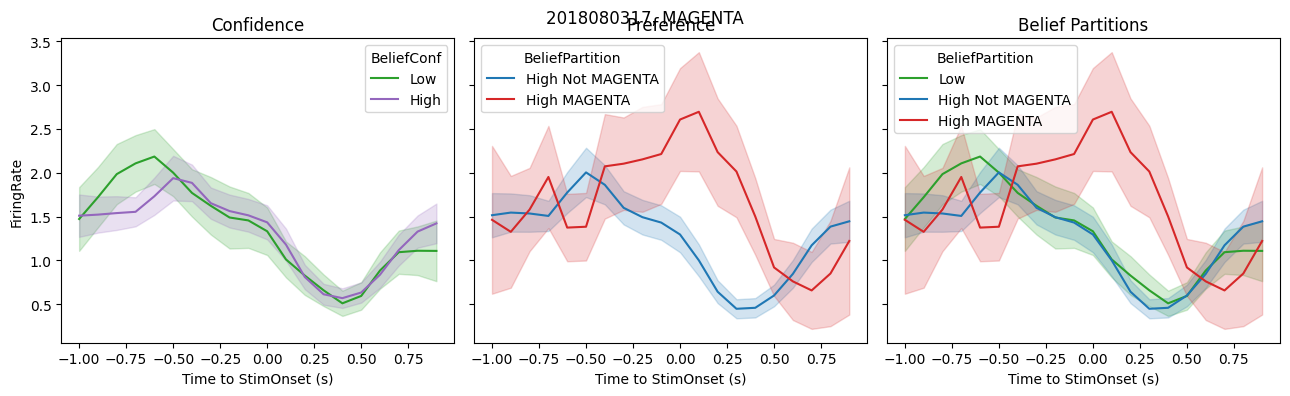

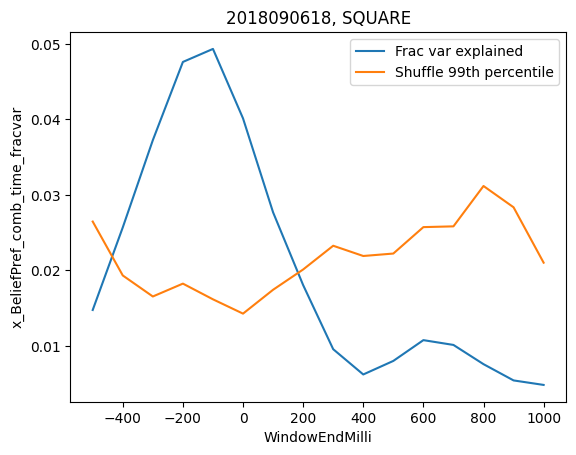

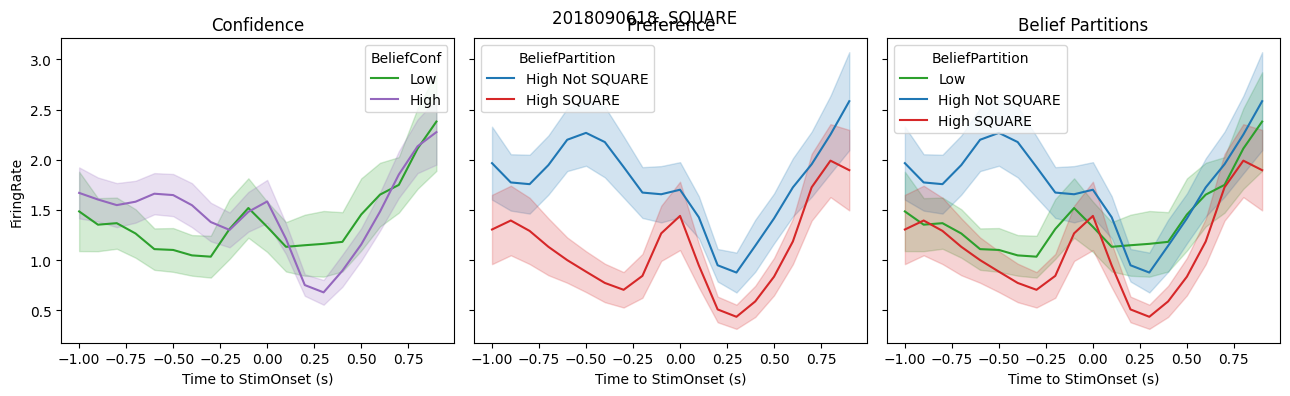

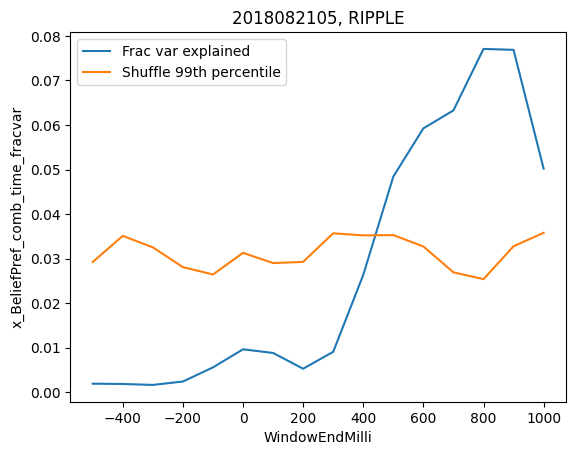

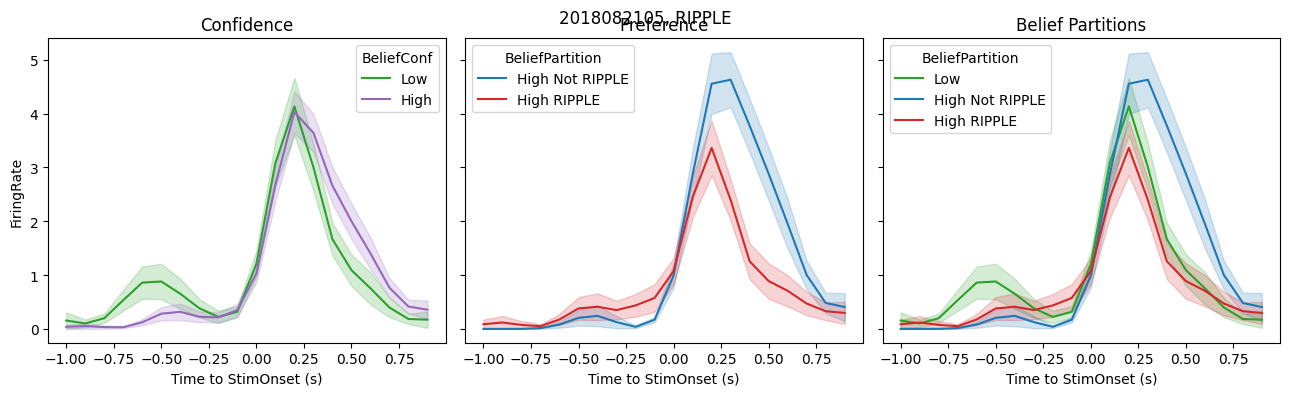

In [16]:
for i, row in max_sig[:5].iterrows():
    unit = row.PseudoUnitID
    feat = row.feat
    sub_res = res[(res.PseudoUnitID == unit) & (res.feat == feat)][["x_BeliefPref_comb_time_fracvar", "PseudoUnitID", "feat", "WindowEndMilli", "BeliefPref_99th"]]
    fig, ax = plt.subplots()
    sns.lineplot(sub_res, x="WindowEndMilli", y="x_BeliefPref_comb_time_fracvar", ax=ax, label="Frac var explained")
    sns.lineplot(sub_res, x="WindowEndMilli", y="BeliefPref_99th", ax=ax, label="Shuffle 99th percentile")
    ax.set_title(f"{unit}, {feat}")
    fig, _ = visualization_utils.plot_belief_partition_psth(unit, feat, args)    
    fig.suptitle(f"{unit}, {feat}")

### What about examples with high frac variance explained?

In [17]:
max_frac = res.groupby(["PseudoUnitID", "feat"]).x_BeliefPref_comb_time_fracvar.max().reset_index(name="max_frac")
max_frac = max_frac.sort_values(by="max_frac", ascending=False)

In [18]:
max_frac

PseudoUnitID      feat  max_frac
3831    2018090712    SQUARE  0.158317
1996    2018080803  POLKADOT  0.158102
4504    2018091907     GREEN  0.136160
4576    2018091921      STAR  0.112250
4646    2018092005    SQUARE  0.109032
...            ...       ...       ...
5218    2018092601  TRIANGLE       NaN
5479    2018100106     GREEN       NaN
5480    2018100106   MAGENTA       NaN
5481    2018100106  POLKADOT       NaN
5728    2018100412   MAGENTA       NaN

[6149 rows x 3 columns]

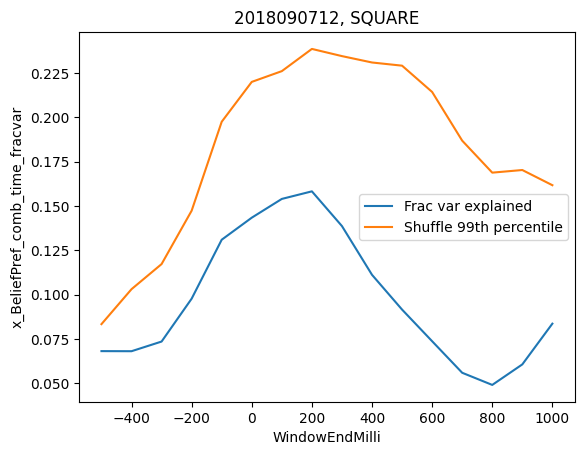

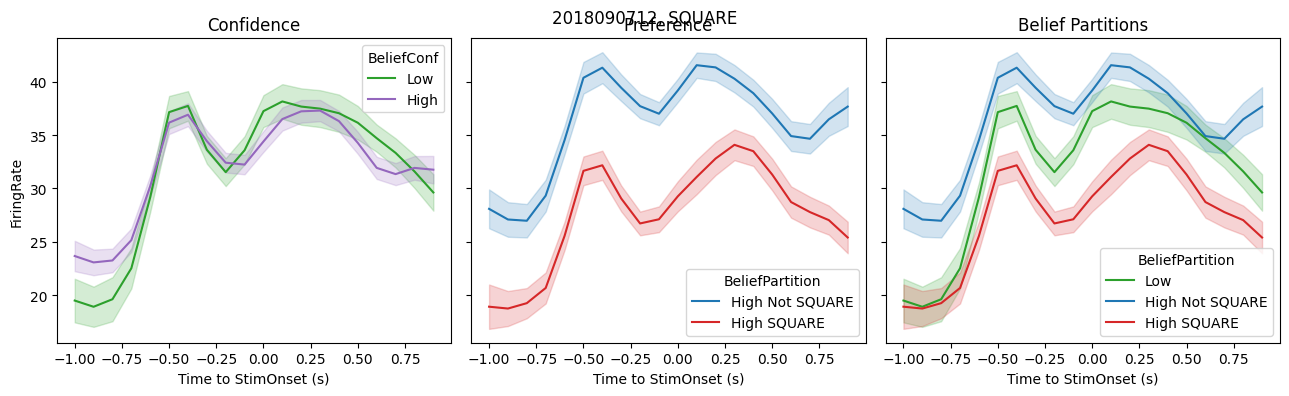

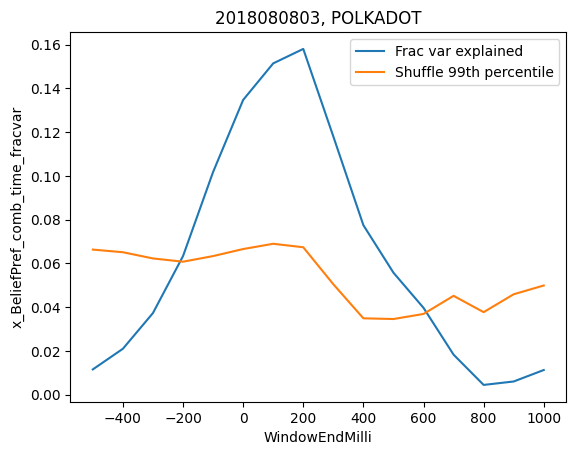

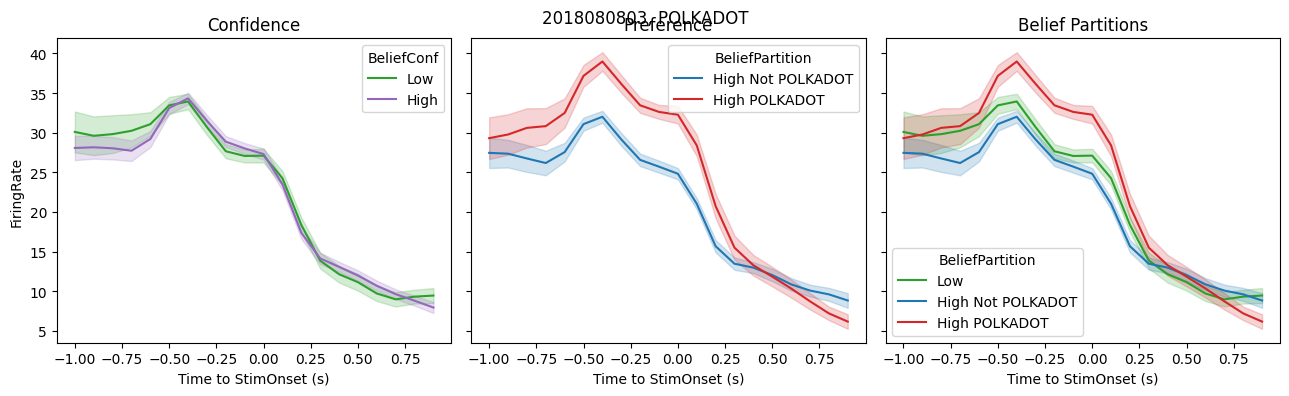

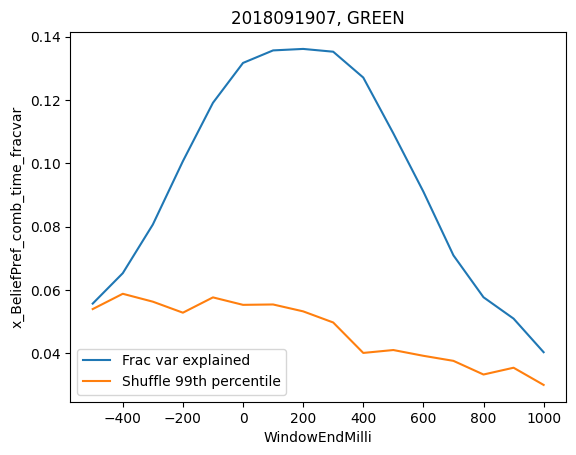

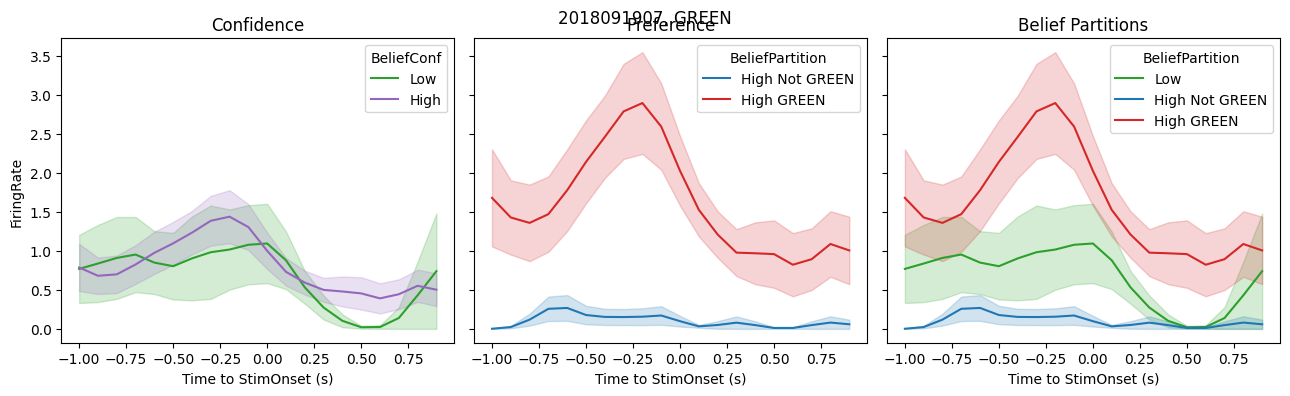

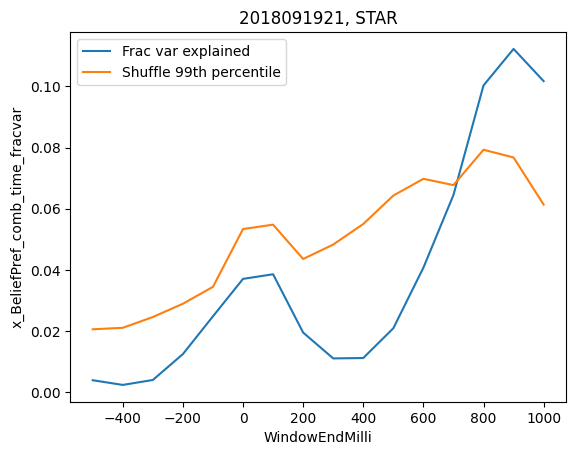

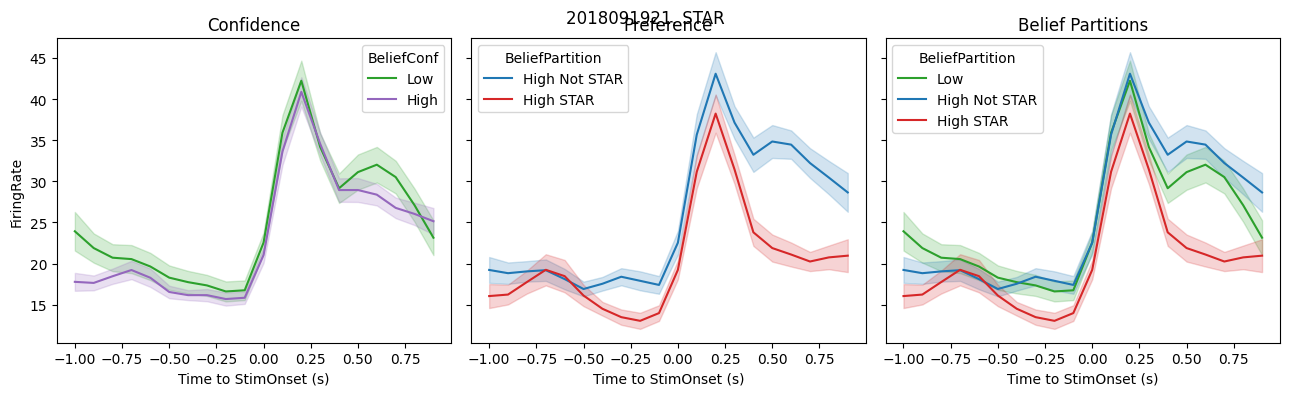

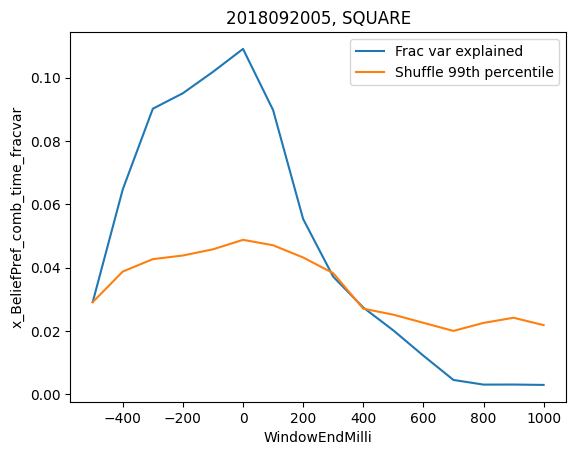

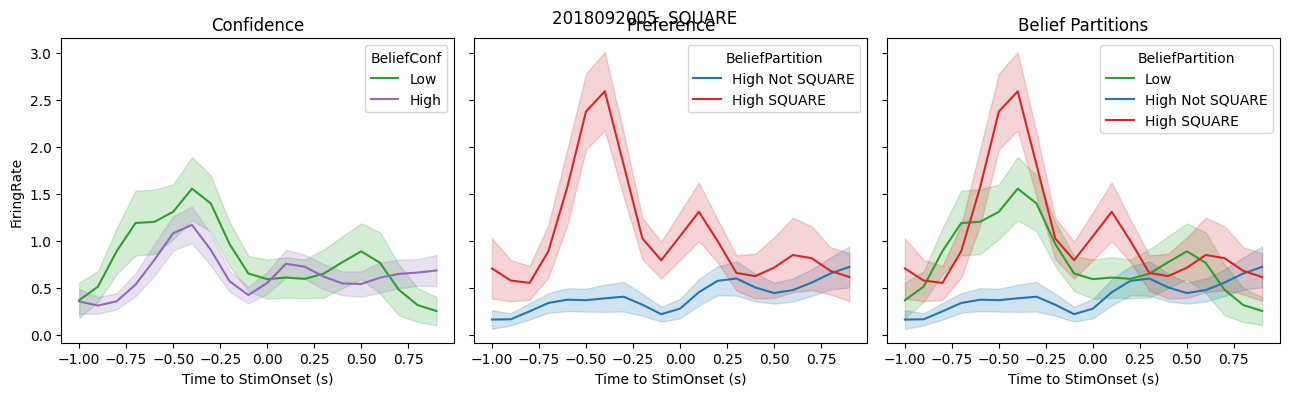

In [19]:
for i, row in max_frac[:5].iterrows():
    unit = row.PseudoUnitID
    feat = row.feat
    sub_res = res[(res.PseudoUnitID == unit) & (res.feat == feat)][["x_BeliefPref_comb_time_fracvar", "PseudoUnitID", "feat", "WindowEndMilli", "BeliefPref_99th"]]
    fig, ax = plt.subplots()
    sns.lineplot(sub_res, x="WindowEndMilli", y="x_BeliefPref_comb_time_fracvar", ax=ax, label="Frac var explained")
    sns.lineplot(sub_res, x="WindowEndMilli", y="BeliefPref_99th", ax=ax, label="Shuffle 99th percentile")
    ax.set_title(f"{unit}, {feat}")
    fig, _ = visualization_utils.plot_belief_partition_psth(unit, feat, args)    
    fig.suptitle(f"{unit}, {feat}")

### Wonder what PSTHs of units look like where they're selective for two features

In [22]:
sig_feats = res[(res.sig_ratio > 1.5) & (res.x_BeliefPref_comb_time_fracvar > 0.01)].groupby("PseudoUnitID").feat.unique().reset_index(name="sig_feats")
sig_feats["n_sig_feats"] = sig_feats.sig_feats.apply(lambda x: len(x))
sig_feats = sig_feats.sort_values(by="n_sig_feats", ascending=False)

In [23]:
sig_feats

PseudoUnitID                    sig_feats  n_sig_feats
48       2018080336       [STAR, CYAN, POLKADOT]            3
55       2018080625     [SQUARE, GREEN, MAGENTA]            3
47       2018080330     [CIRCLE, STAR, TRIANGLE]            3
35       2018080228  [CIRCLE, TRIANGLE, MAGENTA]            3
185      2018100514           [POLKADOT, RIPPLE]            2
..              ...                          ...          ...
76       2018081716                      [GREEN]            1
77       2018081725                       [STAR]            1
78       2018082005                     [SQUARE]            1
79       2018082007                    [MAGENTA]            1
196  20180725000137                     [YELLOW]            1

[197 rows x 3 columns]

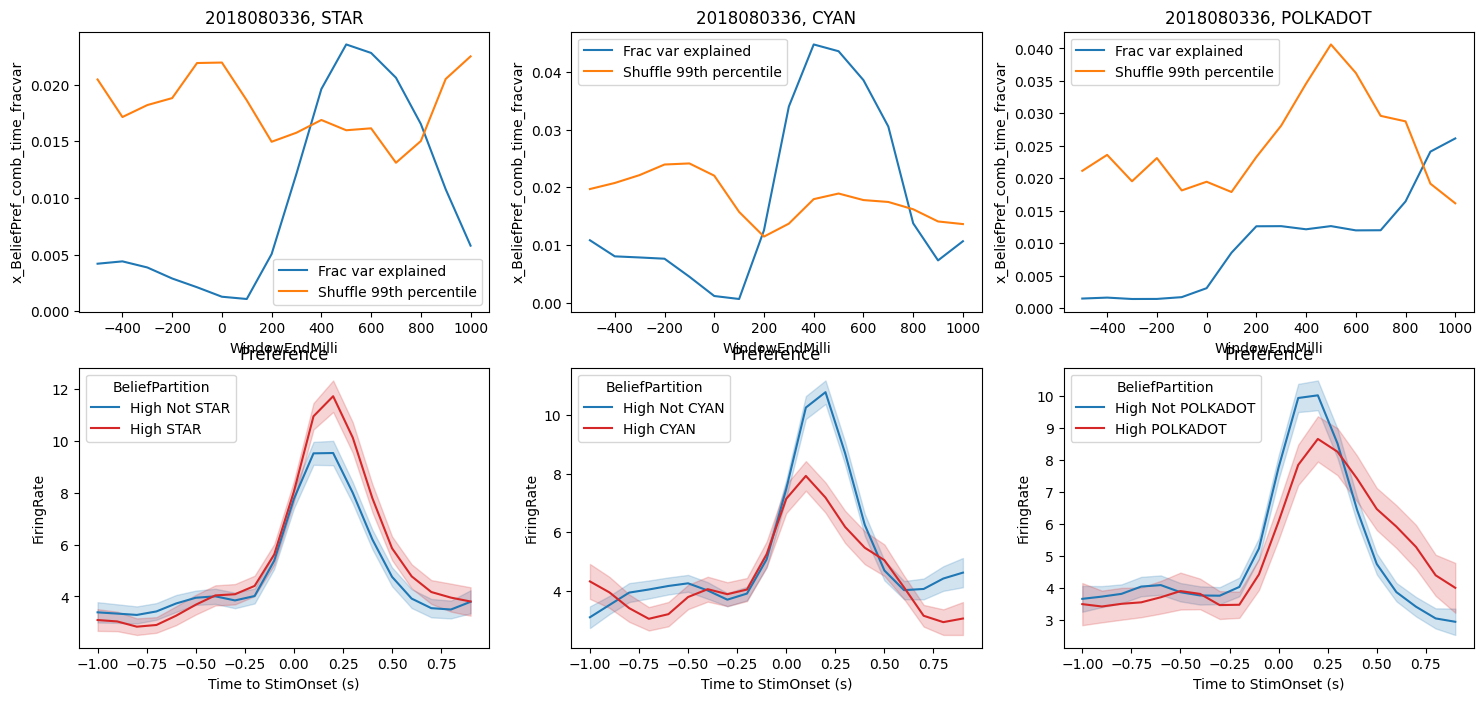

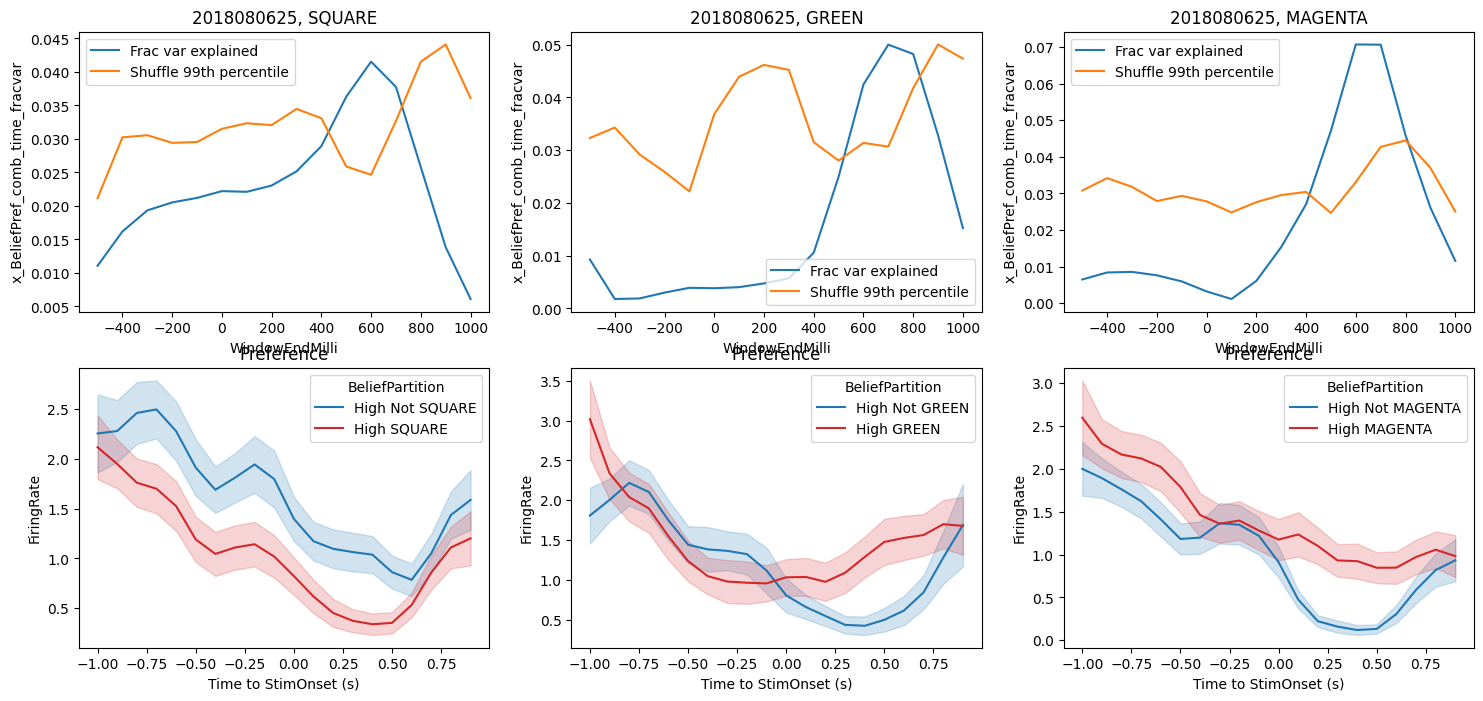

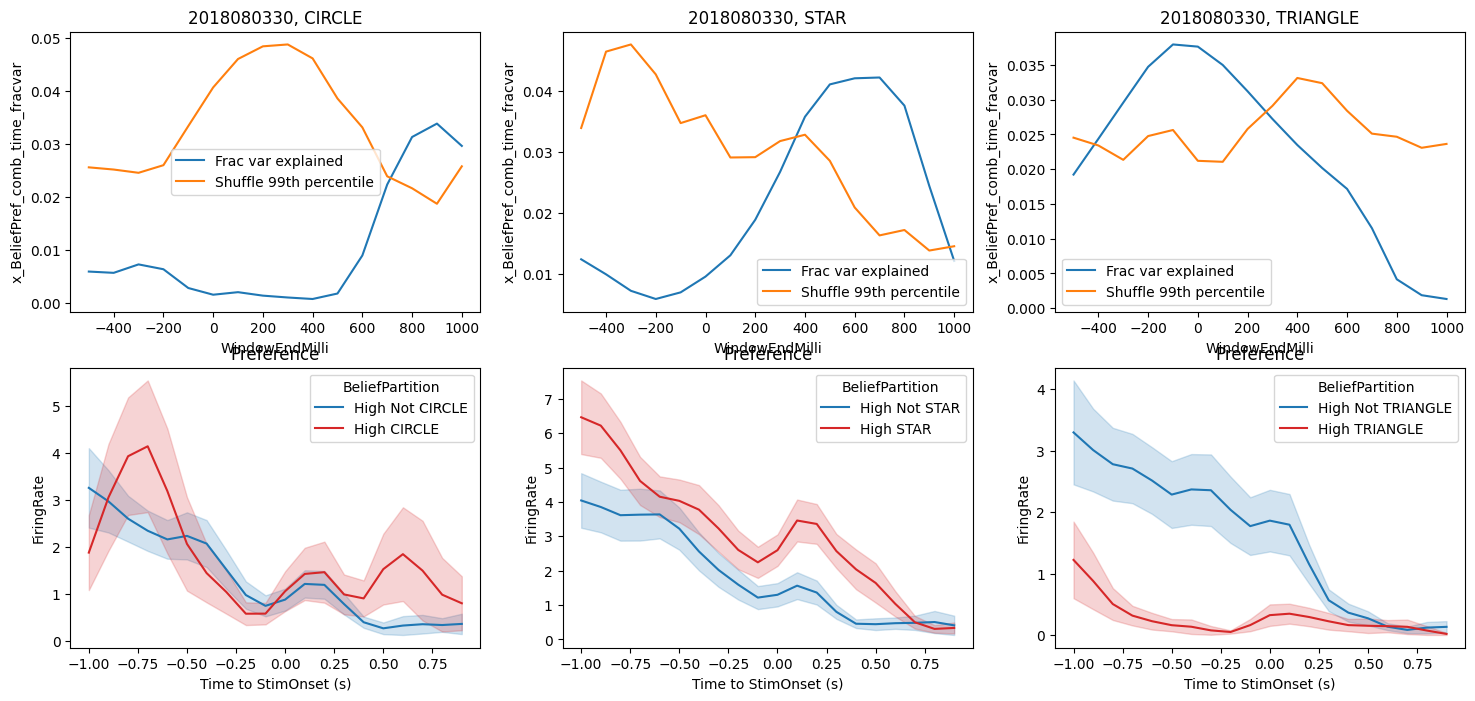

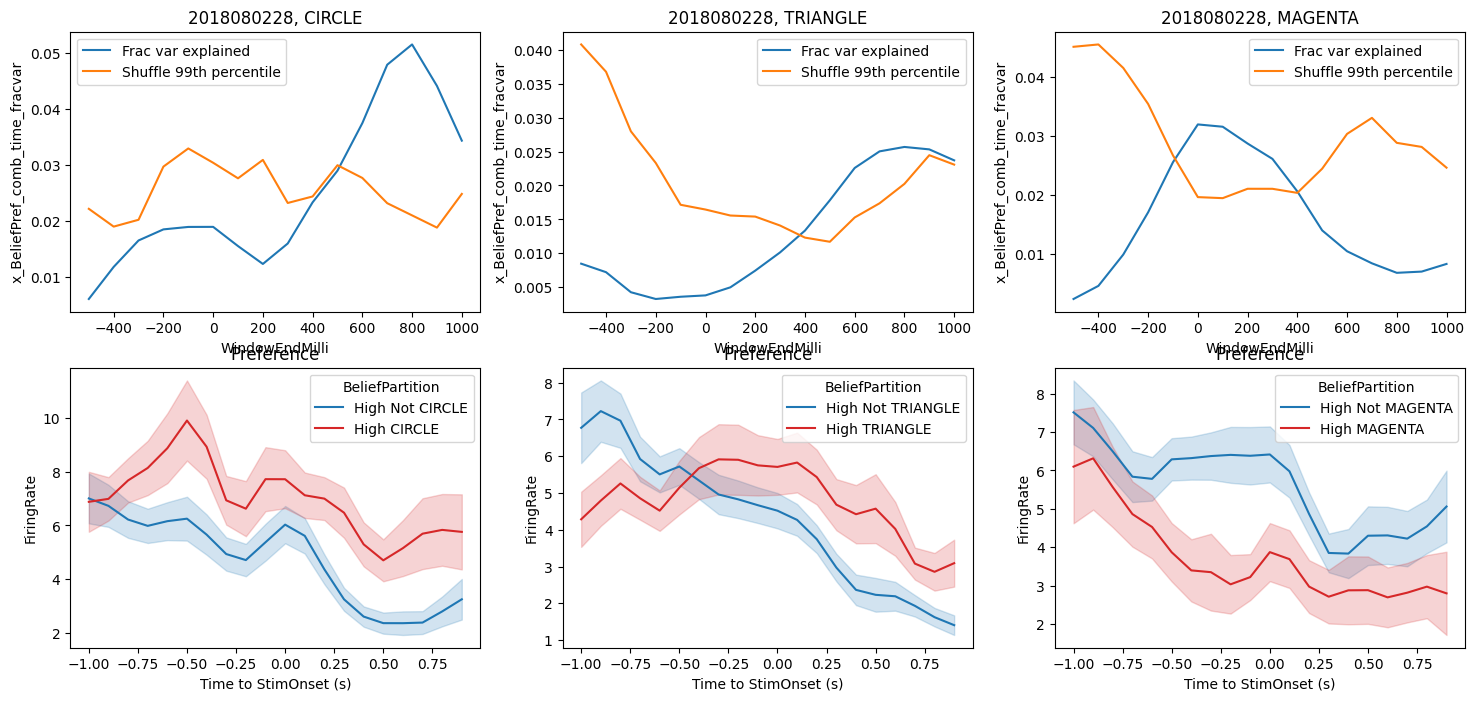

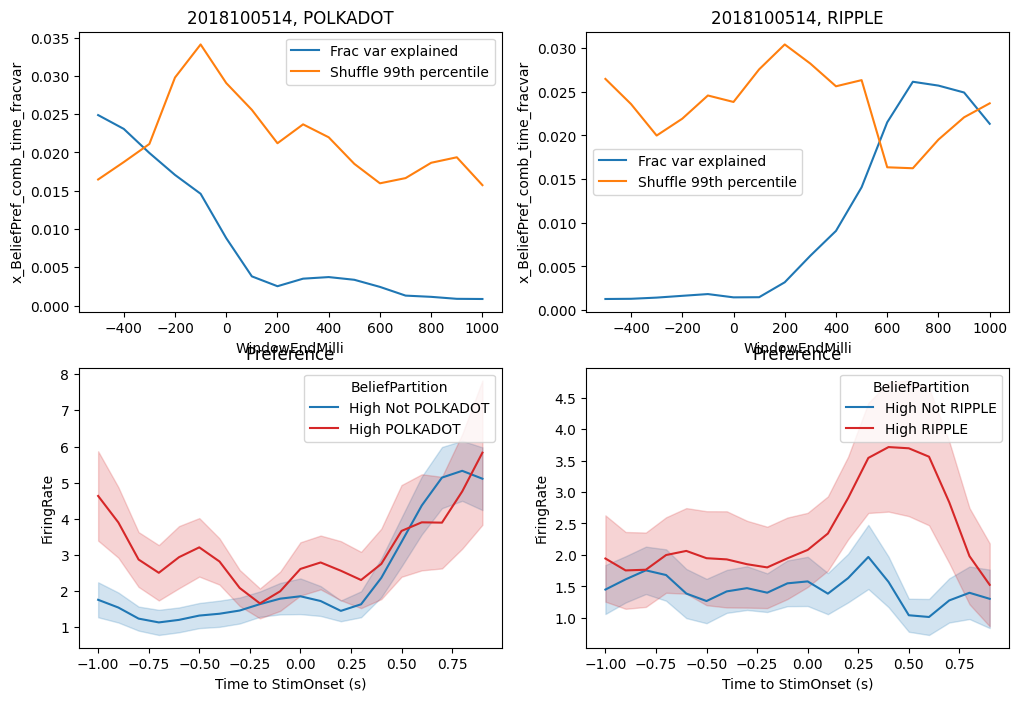

In [24]:
for i, row in sig_feats[:5].iterrows():
    unit = row.PseudoUnitID
    feats = row.sig_feats
    fig, axs = plt.subplots(2, len(feats), figsize=(len(feats) * 6, 8), squeeze=False)
    for feat_idx, feat in enumerate(feats):
        sub_res = res[(res.PseudoUnitID == unit) & (res.feat == feat)][["x_BeliefPref_comb_time_fracvar", "PseudoUnitID", "feat", "WindowEndMilli", "BeliefPref_99th"]]
        sns.lineplot(sub_res, x="WindowEndMilli", y="x_BeliefPref_comb_time_fracvar", ax=axs[0, feat_idx], label="Frac var explained")
        sns.lineplot(sub_res, x="WindowEndMilli", y="BeliefPref_99th", ax=axs[0, feat_idx], label="Shuffle 99th percentile")
        axs[0, feat_idx].set_title(f"{unit}, {feat}")


        args.feat = feat
        session = int(unit / 100)
        beh, frs = load_data(session, args, return_merged=False)
        frs = frs[frs.PseudoUnitID == unit]

        sub_beh = beh[beh.BeliefPartition.isin([f"High {args.feat}", f"High Not {args.feat}"])]
        order = [f"High Not {args.feat}", f"High {args.feat}"]
        colors = ["tab:blue", "tab:red"]

        ax = axs[1, feat_idx]
        sns.lineplot(pd.merge(frs, sub_beh, on="TrialNumber"), x="Time", y="FiringRate", errorbar="se", hue="BeliefPartition", hue_order=order, palette=colors, ax=ax)
        ax.set_xlabel(f"Time to {args.trial_event} (s)")
        ax.set_title("Preference")

### For some feature, plot hist of frac var explained, sorted by peak:

In [3]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500
args.subject = "SA"
args.trial_event = "FeedbackOnsetLong"
res = io_utils.read_anova_good_units(args, "all", "")

feat = "SQUARE"
res = res[res.feat == feat]
res = res[~res.x_BeliefPref_comb_time_fracvar.isna()]

In [4]:
res

PseudoUnitID  total_var  x_TimeBins_fracvar  x_BeliefConf_fracvar  \
29        2018070900   1.095445            0.000957              0.004115   
30        2018070900   1.119554            0.000547              0.008834   
31        2018070900   1.182419            0.002403              0.011459   
32        2018070900   1.277037            0.002976              0.010302   
33        2018070900   1.421346            0.001861              0.007483   
...              ...        ...                 ...                   ...   
141515    2018092821   5.542460            0.020020              0.000565   
141516    2018092821   5.058370            0.020662              0.001588   
141517    2018092821   4.487060            0.013337              0.003051   
141518    2018092821   4.192265            0.008573              0.003584   
141519    2018092821   4.712251            0.005211              0.003329   

        x_BeliefPartition_fracvar  x_TimeBinsBeliefConf_fracvar  \
29                       0.004713                      0.006001   
30                       0.008838                      0.009834   
31                       0.012079                      0.011951   
32                       0.013847                      0.010858   
33                       0.014324                      0.008624   
...                           ...                           ...   
141515                   0.000825                      0.002243   
141516                   0.001588                      0.002325   
141517                   0.003077                      0.003239   
141518                   0.003609                      0.003829   
141519                   0.003333                      0.003599   

        x_TimeBinsBeliefPartition_fracvar  \
29                               0.012493   
30                               0.017782   
31                               0.016595   
32                               0.011985   
33                               0.010204   
...                                   ...   
141515                           0.003509   
141516                           0.002781   
141517                           0.003422   
141518                           0.004030   
141519                           0.003773   

        x_BeliefConfBeliefPartition_fracvar  \
29                                 0.004115   
30                                 0.008834   
31                                 0.011459   
32                                 0.010302   
33                                 0.007483   
...                                     ...   
141515                             0.000565   
141516                             0.001588   
141517                             0.003051   
141518                             0.003584   
141519                             0.003329   

        x_TimeBinsBeliefConfBeliefPartition_fracvar  residual_fracvar  ...  \
29                                         0.018345          0.985952  ...   
30                                         0.036336          0.981667  ...   
31                                         0.046329          0.980382  ...   
32                                         0.041763          0.981494  ...   
33                                         0.031074          0.981094  ...   
...                                             ...               ...  ...   
141515                                     0.003938          0.976211  ...   
141516                                     0.007089          0.976557  ...   
141517                                     0.012393          0.983216  ...   
141518                                     0.014582          0.987372  ...   
141519                                     0.013585          0.991012  ...   

        BeliefConf_95th  BeliefConf_99th  BeliefPartition_95th  \
29             0.028130         0.030480              0.033663   
30             0.024836         0.043759              0.035810   
31             0.020617         0.063

<Axes: xlabel='WindowEndMilli', ylabel='PseudoUnitID'>

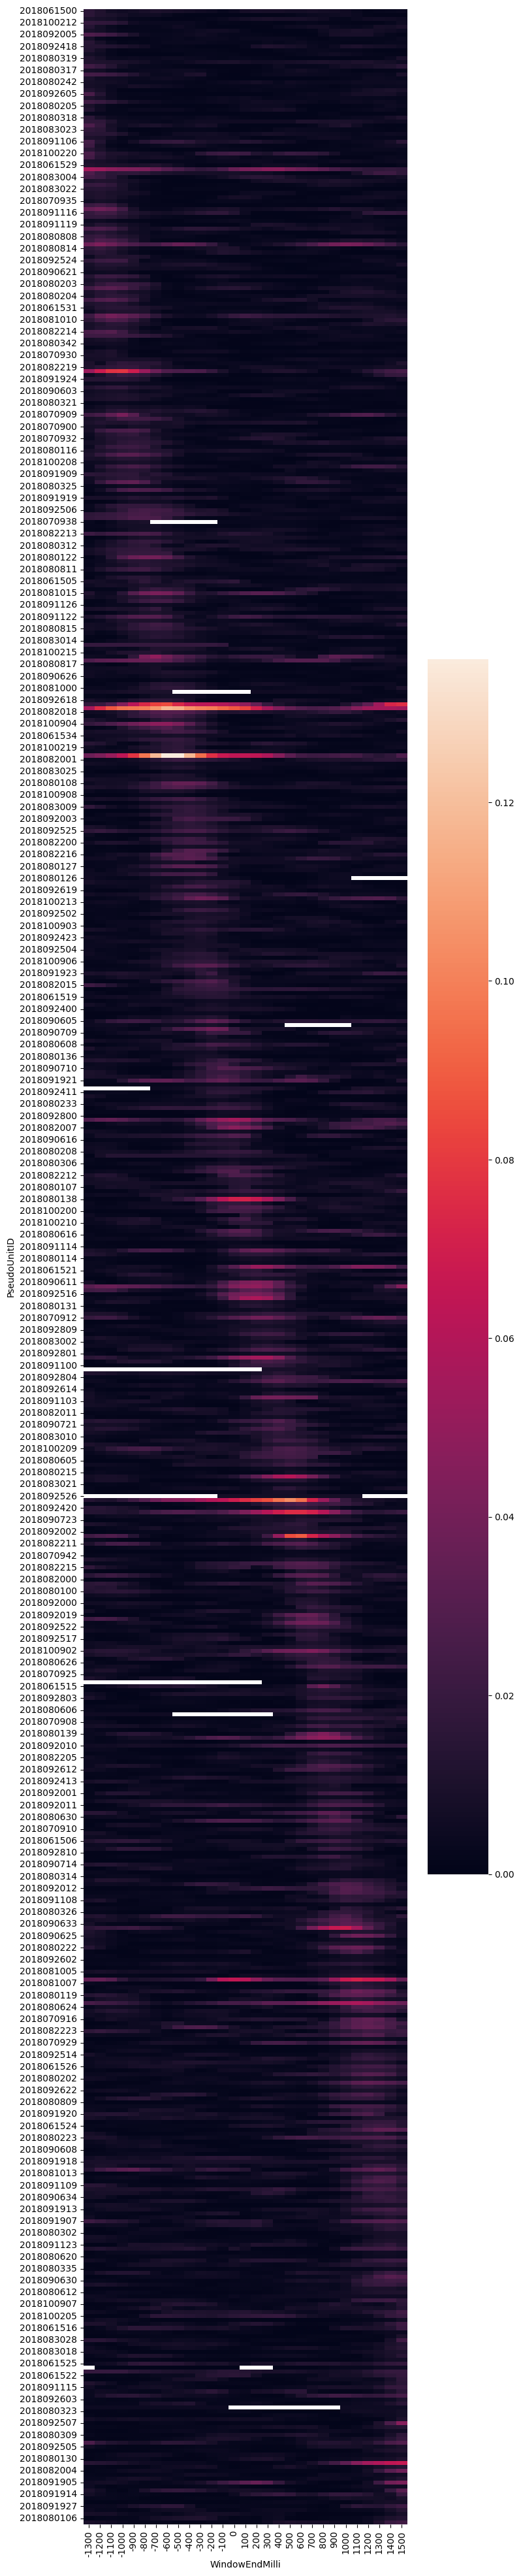

In [10]:
var = "x_BeliefPref_comb_time_fracvar"

def find_peak(group):
    row_idx = group[var].idxmax()
    return group.loc[row_idx].WindowEndMilli

peaks = res.groupby("PseudoUnitID").apply(find_peak).reset_index(name="peak_time")
order = peaks.sort_values(by="peak_time").PseudoUnitID

pivoted = res.pivot(index="PseudoUnitID", columns="WindowEndMilli", values=var)
pivoted = pivoted.loc[order]
fig, ax = plt.subplots(figsize=(8, 50))
sns.heatmap(pivoted, ax=ax)

<Axes: xlabel='WindowEndMilli', ylabel='PseudoUnitID'>

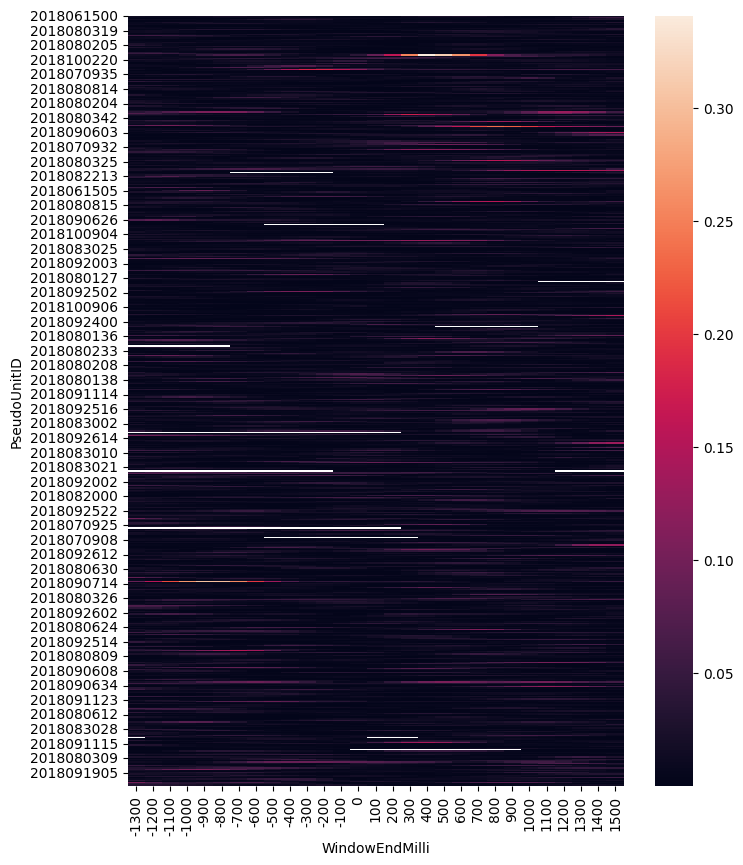

In [47]:
var = "x_BeliefConf_comb_time_fracvar"

pivoted = res.pivot(index="PseudoUnitID", columns="WindowEndMilli", values=var)
pivoted = pivoted.loc[order]
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(pivoted, ax=ax)